# Image Preprocessing Experimentation

This notebook documents the experimentation with various image preprocessing steps.

The general steps taken in this notebook are as follows:
- Understanding the images
- Removing artefacts
- Pectoral muscle removal
- Orientate
- Pad
- Downsample

**IMAGE PREPROCESSING PIPELINE AFTER EXPERIMENTATION:**

- If `image view == CC`:
    1. Crop --> `CropBorders()`
    2. Min-max normalise --> `MinMaxNormalise()`
    3. Remove artefacts --> `OwnGlobalBinarise()`, `OpenMask()`, `SortContoursByArea()`, `XLargestBlobs()`, `ApplyMask()`
    4. Horizontal-flip --> `HorizontalFlip()`
    5. Pad --> `Pad()`
    6. Downsample --> ???
    7. Min-max normalise --> `MinMaxNormalise()`

   <br>

- If `image view == MLO`:
    1. Crop
    2. Min-max normalise
    3. Remove artefacts
    4. Horizontal flip
    5. Remove pectoral muscle <--- Refer to `removePectoral.ipynb`
    6. Pad
    7. Downsample
    8. Min-max normalise

### Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas            as pd
import numpy             as np
import cv2
import pydicom
import os
import skimage

from pathlib             import Path

### Helper functions

In [2]:
def ShowHist255(img, ignore_zero = False):
    hist, bin_edges = np.histogram(img, bins=255, density=False)
    
    if ignore_zero:
        plt.plot(bin_edges[1:-1], hist[1:])
    else:
        plt.plot(bin_edges[0:-1], hist)
        
    plt.show()

### Read the selected .dcm files

In [25]:
# Paths of selected .dcm files
selected_paths = ["../data/raw_data/Mass/Train/Mass-Training_P_00001_LEFT_CC_FULL.dcm",
                  "../data/raw_data/Mass/Train/Mass-Training_P_00009_RIGHT_MLO_FULL.dcm",
                  "../data/raw_data/Mass/Train/Mass-Training_P_00572_RIGHT_CC_FULL.dcm",
                  "../data/raw_data/Mass/Train/Mass-Training_P_00146_RIGHT_CC_FULL.dcm",
                  "../data/raw_data/Mass/Train/Mass-Training_P_00710_LEFT_MLO_FULL.dcm",
                  "../data/raw_data/Mass/Train/Mass-Training_P_01343_LEFT_CC_FULL.dcm"]

ds = [pydicom.dcmread(selected_paths[i]) for i in range(len(selected_paths))]

arr = [_ds.pixel_array for _ds in ds]

# Paths of corresponding masks
mask_paths = ["../data/raw_data/Mass/Train/Mass-Training_P_00001_LEFT_CC_MASK_1.dcm",
              "../data/raw_data/Mass/Train/Mass-Training_P_00009_RIGHT_MLO_MASK_1.dcm",
              "../data/raw_data/Mass/Train/Mass-Training_P_00572_RIGHT_CC_MASK_1.dcm",
              "../data/raw_data/Mass/Train/Mass-Training_P_00146_RIGHT_CC_MASK_1.dcm",
              "../data/raw_data/Mass/Train/Mass-Training_P_00710_LEFT_MLO_MASK_1.dcm",
              "../data/raw_data/Mass/Train/Mass-Training_P_01343_LEFT_CC_MASK_1.dcm",
              "../data/raw_data/Mass/Train/Mass-Training_P_01343_LEFT_CC_MASK_2.dcm"]

ds_masks = [pydicom.dcmread(mask_paths[i]) for i in range(len(mask_paths))]

arr_masks = [_ds.pixel_array for _ds in ds_masks]

### Visualise the original images

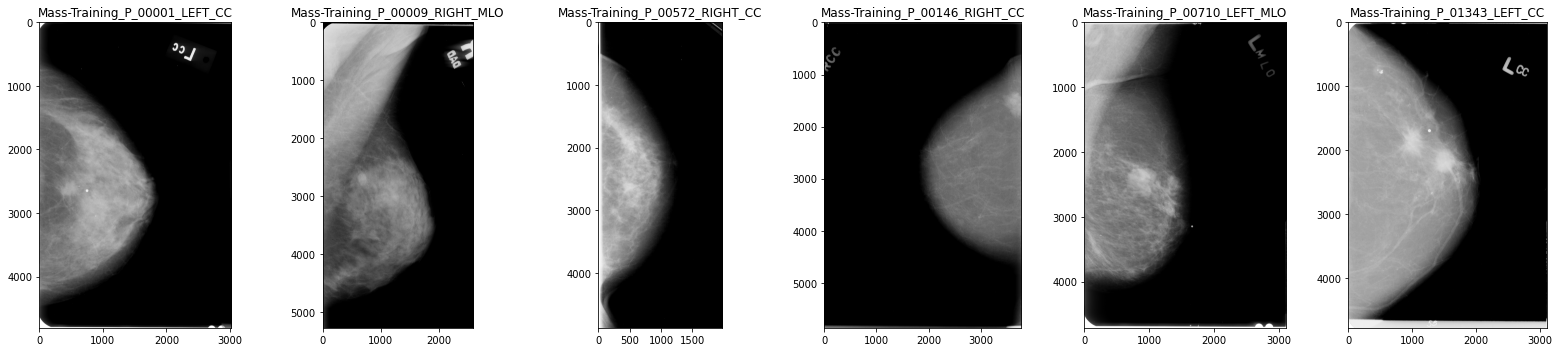

In [18]:
# Plot together
fig, ax = plt.subplots(nrows=1, ncols=len(selected_paths), figsize = (22, 5))

for i in range(len(selected_paths)):
    ax[i].imshow(arr[i], cmap="gray")
    ax[i].set_title(f"{ds[i].PatientID}")
    
plt.tight_layout()
plt.savefig(fname="../data/raw_data/visualisations_for_slides/raw.png", dpi=300)

In [27]:
# Plot individually
for i in range(len(arr)):
    save_path = os.path.join("../data/raw_data/visualisations_for_slides", f"{ds[i].PatientID}_raw_{i}.png")
    cv2.imwrite(filename=save_path, img=arr[i])

### Visualise the corresponding masks

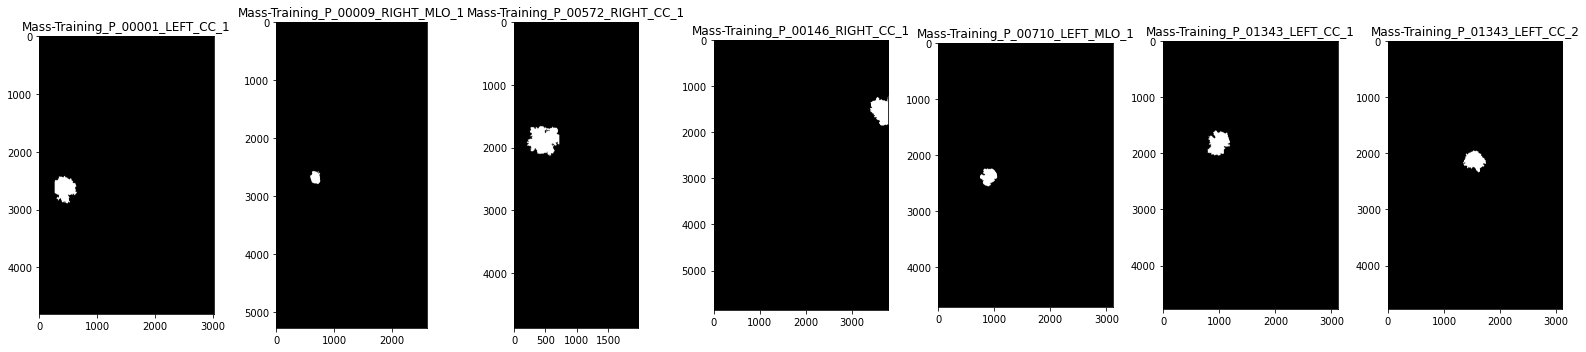

In [26]:
# Plot together
fig, ax = plt.subplots(nrows=1, ncols=len(mask_paths), figsize = (22, 5))

for i in range(len(mask_paths)):
    ax[i].imshow(arr_masks[i], cmap="gray")
    ax[i].set_title(f"{ds_masks[i].PatientID}")
    
plt.tight_layout()
plt.savefig(fname="../data/raw_data/visualisations_for_slides/raw_masks.png", dpi=300)

In [29]:
# Plot individually
for i in range(len(arr_masks)):
    save_path = os.path.join("../data/raw_data/visualisations_for_slides", f"{ds_masks[i].PatientID}.png")
    cv2.imwrite(filename=save_path, img=arr_masks[i])

---

## Understanding the images

### 1. Shape, dtype, range of values


- **Observations:**
    1. Images are not in standard sizes.
    2. `pydicom.pixel_array` method outputs the images in Numpy arrays that have `dtype = uint16`.

In [5]:
for a in arr:
    print("Shape:", a.shape)
    print("Dimensions:", a.ndim)
    print("Type:", type(a))
    print("Data type:", a.dtype)
    print(f"min value, max value: {a.min(), a.max()}")
    print("---")

Shape: (4808, 3024)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint16
min value, max value: (0, 65535)
---
Shape: (5266, 2596)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint16
min value, max value: (0, 65534)
---
Shape: (4876, 1981)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint16
min value, max value: (0, 65535)
---
Shape: (5864, 3784)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint16
min value, max value: (0, 65535)
---
Shape: (4712, 3120)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: uint16
min value, max value: (0, 65535)
---


### 2. Normalise to range [0, 1]?

- **Observations:**
    1. Doing min-max normalisation changes the intensities in the image (i.e. **the image is DISTORTED using min-max scaling!!!**)
        - [Image datatypes and what they mean](https://scikit-image.org/docs/dev/user_guide/data_types.html)
    2. Normalisation using the below method changes the image array to `dtype = float32`.
    
- **Conclusions:**
    1. Don't need to normalise for image preprocessing. Only normalise to \[0, 1\] after image preprocessing (before feeding into model).

In [31]:
def MinMaxNormalise(img):
    
    '''
    This function does min-max normalisation on
    the given image.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to normalise.
        
    Returns
    -------
    norm_img: {numpy.ndarray}
        The min-max normalised image.
    '''
    
    norm_img = (img - img.min()) / (img.max() - img.min())
    
    return norm_img

In [32]:
arr_norm = [MinMaxNormalise(a) for a in arr]

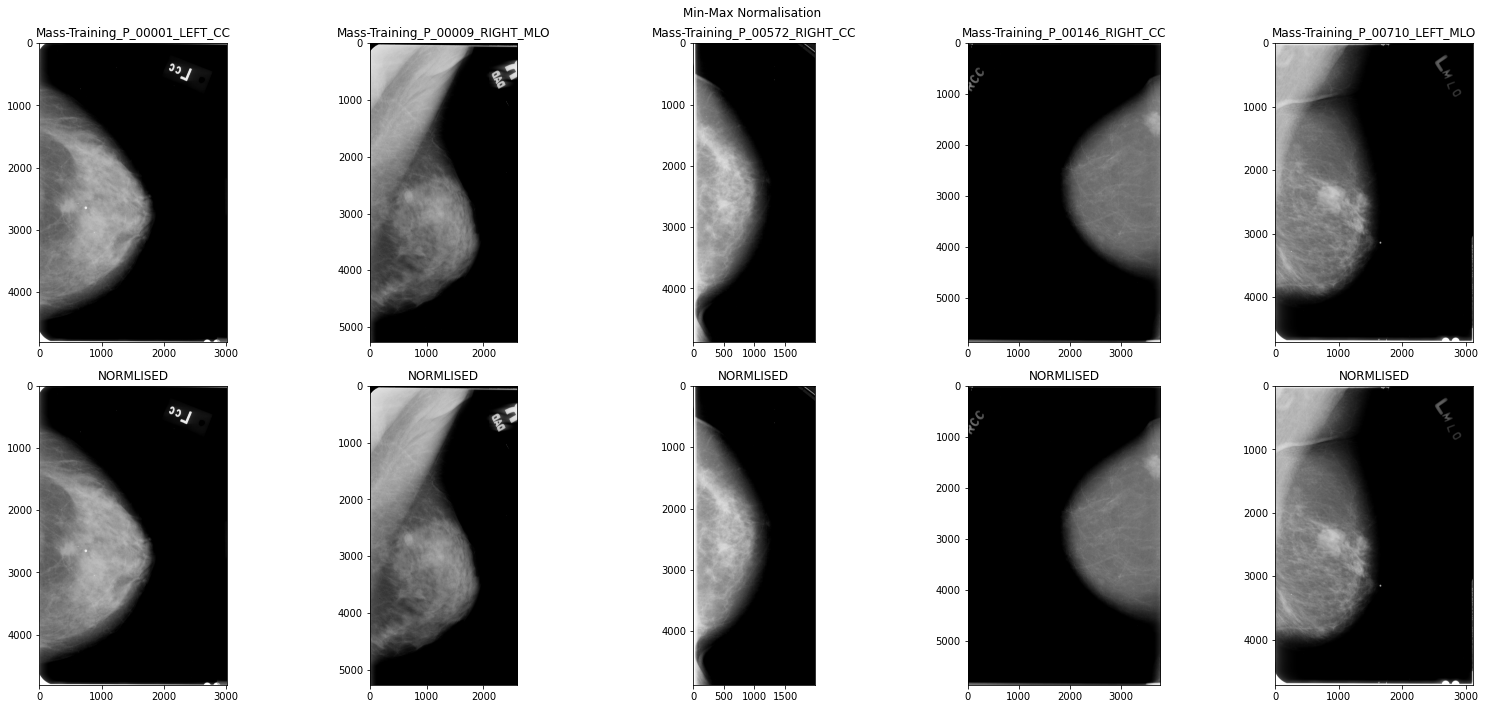

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=len(selected_paths), figsize = (22, 10))

fig.suptitle("Min-Max Normalisation")

# Plot original
for i in range(len(selected_paths)):
    ax[0][i].imshow(arr[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
# Plot normalised
for i in range(len(selected_paths)):
    ax[1][i].imshow(arr_norm[i], cmap="gray")
    ax[1][i].set_title("NORMLISED")
    
plt.tight_layout()
plt.savefig(fname="../outputs/image-preprocessing/normalised.png", dpi=300)

In [8]:
for a in arr:
    print(a.dtype)
    print({a.min(), a.max()})

for a in arr_norm:
    print(a.dtype)
    print({a.min(), a.max()})

uint16
{0, 65535}
uint16
{0, 65534}
uint16
{0, 65535}
uint16
{0, 65535}
uint16
{0, 65535}
float64
{0.0, 1.0}
float64
{0.0, 1.0}
float64
{0.0, 1.0}
float64
{0.0, 1.0}
float64
{0.0, 1.0}


### 3. uint16 (16-bit) -> uint8 (8-bit)

- **Why:**
    1. We have to change from 16-bit to 8-bit because `cv2.threshold` and `cv2.adaptiveThreshold()` requires 8-bit image array.
    
<br>

- **Observations:**
    1. `skimage.img_as_ubyte()` does not seem to change the relative intensities within each image as drastically as min-max normalisation.
    2. BUT converting from `uint16` to `uint8` removes the granularity of the information in an image.

<br>

- **Conclusions:**
    1. Should not convert to `uint8`.

In [9]:
arr_uint8 = [skimage.img_as_ubyte(a) for a in arr]

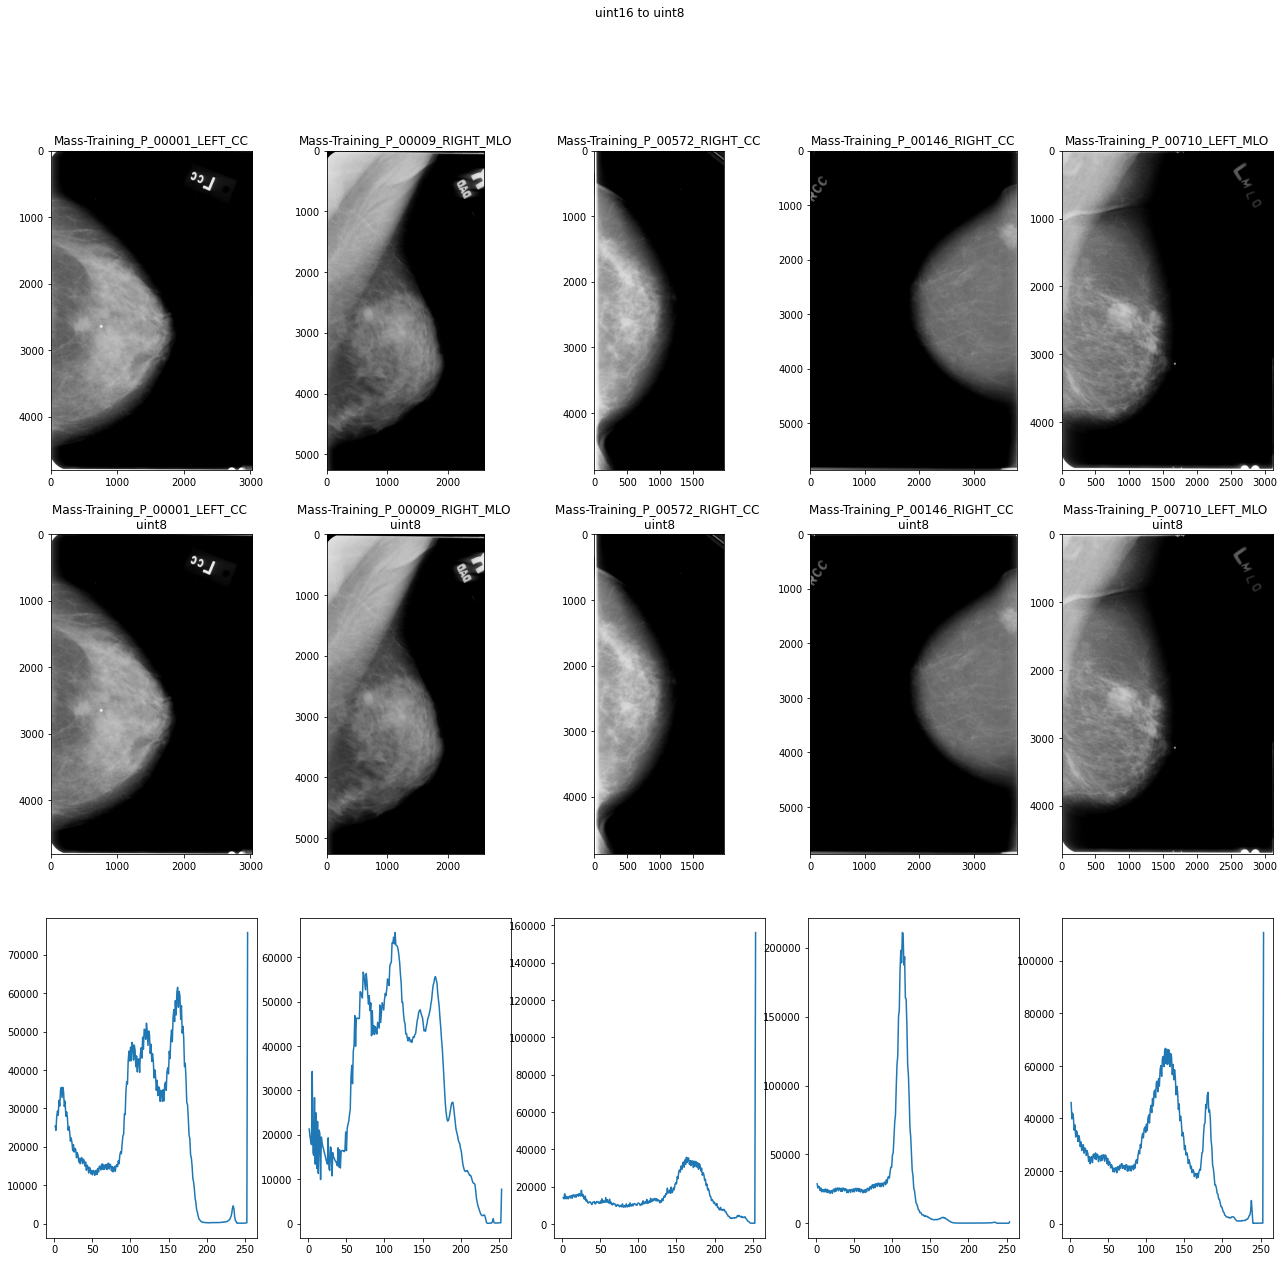

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=len(selected_paths), figsize = (22, 20))

fig.suptitle("uint16 to uint8")

# Plot original uint16
for i in range(len(selected_paths)):
    ax[0][i].imshow(arr[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
# Plot uint8
for i in range(len(selected_paths)):
    ax[1][i].imshow(arr_uint8[i], cmap="gray")
    ax[1][i].set_title(f"{ds[i].PatientID} \nuint8")
    
# Plot histogram of uint8 (ignoring 0)
for i in range(len(selected_paths)):
    hist, bin_edges = np.histogram(arr_uint8[i], bins=255, density=False)
    ax[2][i].plot(bin_edges[1:-1], hist[1:])
    
# plt.tight_layout()
# plt.savefig(fname="../outputs/image-preprocessing/uint8.png", dpi=300)

In [11]:
for a in arr:
    print(a.dtype)
    print(a.min(), a.max())

for a in arr_uint8:
    print(a.dtype)
    print(a.min(), a.max())

uint16
0 65535
uint16
0 65534
uint16
0 65535
uint16
0 65535
uint16
0 65535
uint8
0 255
uint8
0 255
uint8
0 255
uint8
0 255
uint8
0 255


---

## Initial crop around the image boundaries

- **Why:**
    - Some scans have a white border on some/all sides of the frame. Taking away a small percentage of the image on all sides might remove this border while not removing too much of the image such that we lose valuable information.

In [39]:
def CropBorders(img):
    
    '''
    This function crops 1% from all four sides of the given
    image.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to crop.
        
    Returns
    -------
    cropped_img: {numpy.ndarray}
        The cropped image.
    '''
    nrows, ncols = img.shape

    # Get the start and end rows and columns
    l_crop = int(ncols * 0.01)
    r_crop = int(ncols * (1 - 0.04))
    u_crop = int(nrows * 0.01)
    d_crop = int(nrows * (1 - 0.04))

    cropped_img = img[u_crop:d_crop, l_crop:r_crop]
    
    return cropped_img

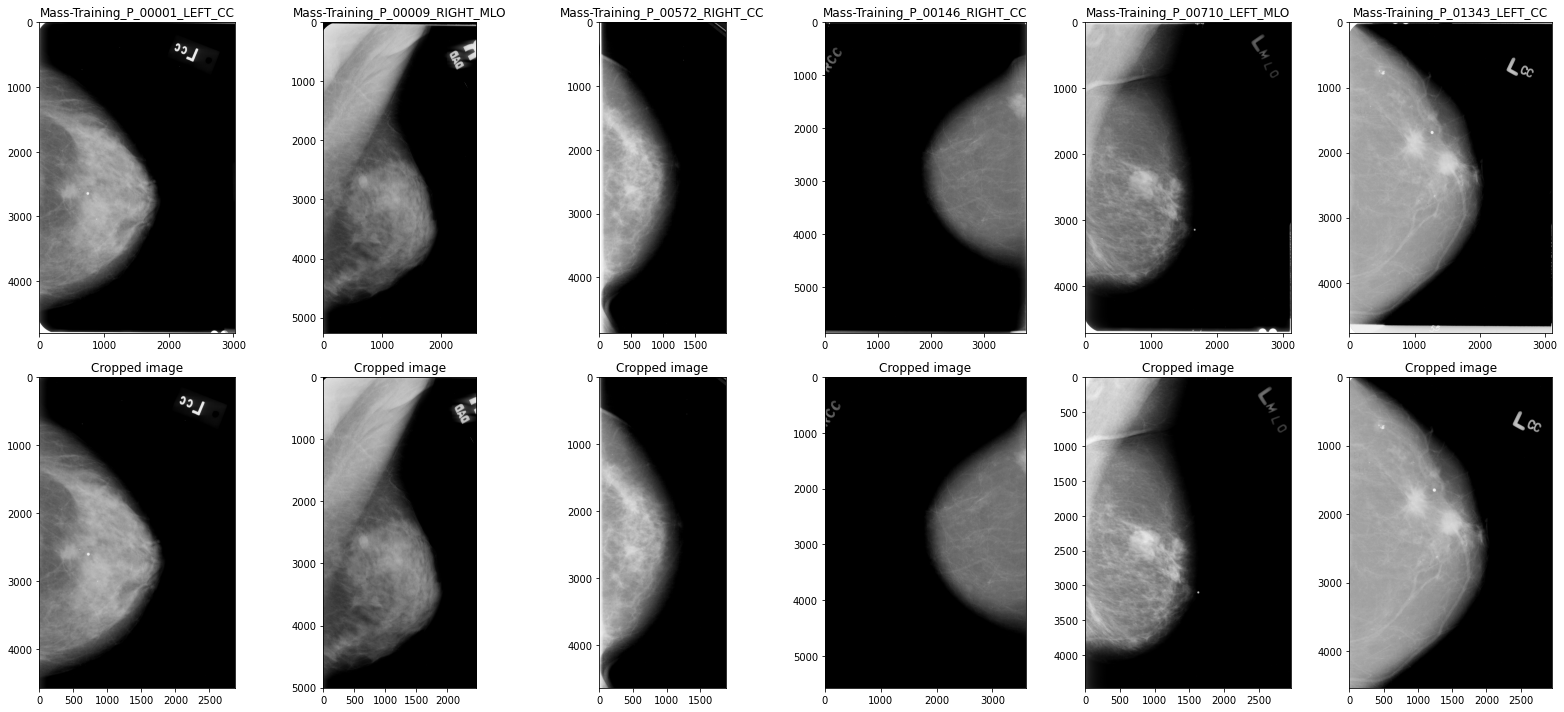

In [40]:
cropped_img_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(selected_paths), figsize = (22, 10))

for i in range(len(arr_norm)):
    
    # Plot original
    ax[0][i].imshow(arr_norm[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
    # Plot cropped
    cropped_img = CropBorders(img=arr_norm[i])
    cropped_img_list.append(cropped_img)
    ax[1][i].imshow(cropped_img, cmap="gray")
    ax[1][i].set_title("Cropped image")

    
plt.tight_layout()
plt.savefig(fname="../data/raw_data/visualisations_for_slides/1_cropped.png", dpi=150)

In [41]:
# Plot individually
for i in range(len(cropped_img_list)):
    save_path = os.path.join("../data/raw_data/visualisations_for_slides/1_cropped", f"{ds[i].PatientID}_cropped.png")
    cv2.imwrite(filename=save_path, img=cropped_img_list[i]*255)


---

## Removing artefacts using OpenCV `inpaint()`


- **Proposed method:**
    - Step 1: Get mask of artefacts
        - Step 1.1: Binarise (methods of binarising can vary)
        - Step 1.2: Removing noise from mask
        - Step 1.3: Remove the breast region from the mask
    - Step 2: Inpaint using the mask
        - Step 2.1: Invert mask
        - Step 2.2: inpaint

### Step 1 - Get mask of artifacts (a.k.a binarisation a.k.a thresholding)

#### Step 1.1 - Try to binarise using `cv2.theshold()` and `cv2.adaptiveThreshold()`

- **References:**
    - [Creating mask using thresholding](https://stackoverflow.com/questions/53592055/opencv-remove-text-from-image?noredirect=1&lq=1)
    - [`threshold` documentation](https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57)
    - [`adaptiveThreshold` documentation](https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#ga72b913f352e4a1b1b397736707afcde3)
    - [Explanation of Otsu's thresholding](https://www.learnopencv.com/otsu-thresholding-with-opencv/)
    
- **Observations:**
    - `cv2.threshold()` and `cv2.adaptiveThreshold()` requires the input image to be `dtype=uint8`. This is not ideal, we lose granularity in the information when we convert from `float64` to `uint8`.

In [12]:
def Binarisation(img, maxval, show=False):
    
    # First convert image to uint8.
    img = skimage.img_as_ubyte(img)
    
    thresh, th1 = cv2.threshold(src=img,
                                thresh=0.1,
                                maxval=maxval,
                                type=cv2.THRESH_BINARY) # Global thresholding

    otsu_thresh, th2 = cv2.threshold(src=img,
                                     thresh=0,
                                     maxval=maxval,
                                     type=cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Otsu's thresholding

    th3 = cv2.adaptiveThreshold(src=img,
                                maxValue=maxval,
                                adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
                                thresholdType=cv2.THRESH_BINARY,
                                blockSize=9,
                                C=-1)
    
    th4 = cv2.adaptiveThreshold(src=img,
                                maxValue=maxval,
                                adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                thresholdType=cv2.THRESH_BINARY,
                                blockSize=9,
                                C=-1)

    images = [img, th1, th2, th3, th4]
    titles = ['Original Image',
              'Global Thresholding (v = 0.1)',
              'Global Thresholding (otsu)',
              'Adaptive Mean Thresholding',
              'Adaptive Gaussian Thresholding']

    
    # --- Plot the different thresholds ---
    if show:
        fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (22, 5))

        for i in range(5):
            ax[i].imshow(images[i], cmap="gray")
            ax[i].set_title(titles[i])
        plt.show()
    
    return th1, th2, th3, th4


def DilateMask(mask):
    
    # Dilate mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated_mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
    
    return dilated_mask


def ApplyMask(img, dilated_mask):

    # Apply change
    result = img.copy()
    result[dilated_mask == 0] = 0 # We only keep areas that are white (255)
    
    return result

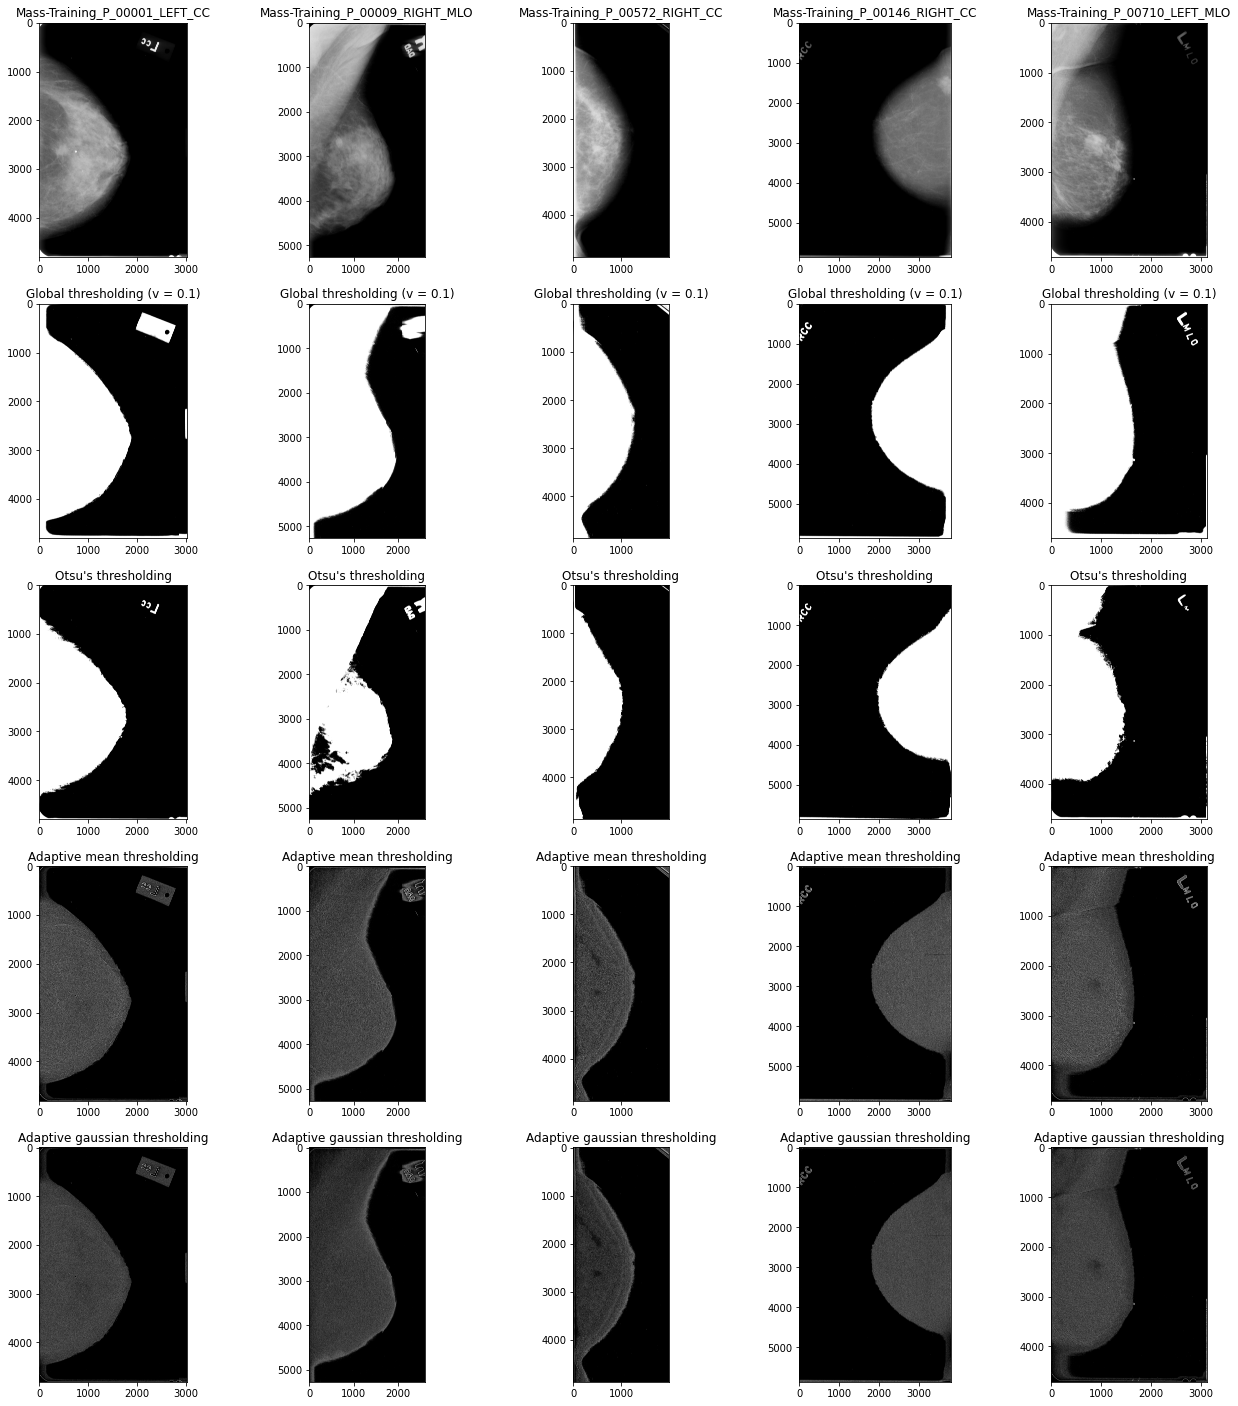

In [13]:
th1_list = []
th2_list = []
th3_list = []
th4_list = []

# Plot binarised images
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(22, 25))

for i in range(len(arr_norm)):
    
    # Plot original image.
    ax[0][i].imshow(arr_norm[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
    # Plot binarised images.
    th1, th2, th3, th4 = Binarisation(img=arr_norm[i], maxval=1.0, show=False)
    th1_list.append(th1)
    th2_list.append(th2)
    th3_list.append(th3)
    th4_list.append(th4)
    
    ax[1][i].imshow(th1, cmap="gray")
    ax[1][i].set_title("Global thresholding (v = 0.1)")
    
    ax[2][i].imshow(th2, cmap="gray")
    ax[2][i].set_title("Otsu's thresholding")
    
    ax[3][i].imshow(th3, cmap="gray")
    ax[3][i].set_title("Adaptive mean thresholding")
    
    ax[4][i].imshow(th4, cmap="gray")
    ax[4][i].set_title("Adaptive gaussian thresholding")
    
# plt.tight_layout()
# plt.savefig(fname="../outputs/image-preprocessing/binarised.png", dpi=300)

#### Step 1.1 - Try to binarise using my manual function

- **Observations:**
    1. Pros:
        - My method seems to be more accurate and straightforward. Able to pick up both the breast and the various artefacts.
    2. Cons:
        - If there is a white border, the border will be part of the breast contour. Have to remove it at a later stage.

In [42]:
def OwnGlobalBinarise(img, thresh, maxval):
    
    '''
    This function takes in a numpy array image and
    returns a corresponding mask that is a global
    binarisation on it based on a given threshold
    and maxval. Any elements in the array that is
    greater than or equals to the given threshold
    will be assigned maxval, else zero.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to perform binarisation on.
    thresh : {int or float}
        The global threshold for binarisation.
    maxval : {np.uint8}
        The value assigned to an element that is greater
        than or equals to `thresh`.
        
        
    Returns
    -------
    binarised_img : {numpy.ndarray, dtype=np.uint8}
        A binarised image of {0, 1}.
    '''
    
    binarised_img = np.zeros(img.shape, np.uint8)
    binarised_img[img >= thresh] = maxval
    
    return binarised_img

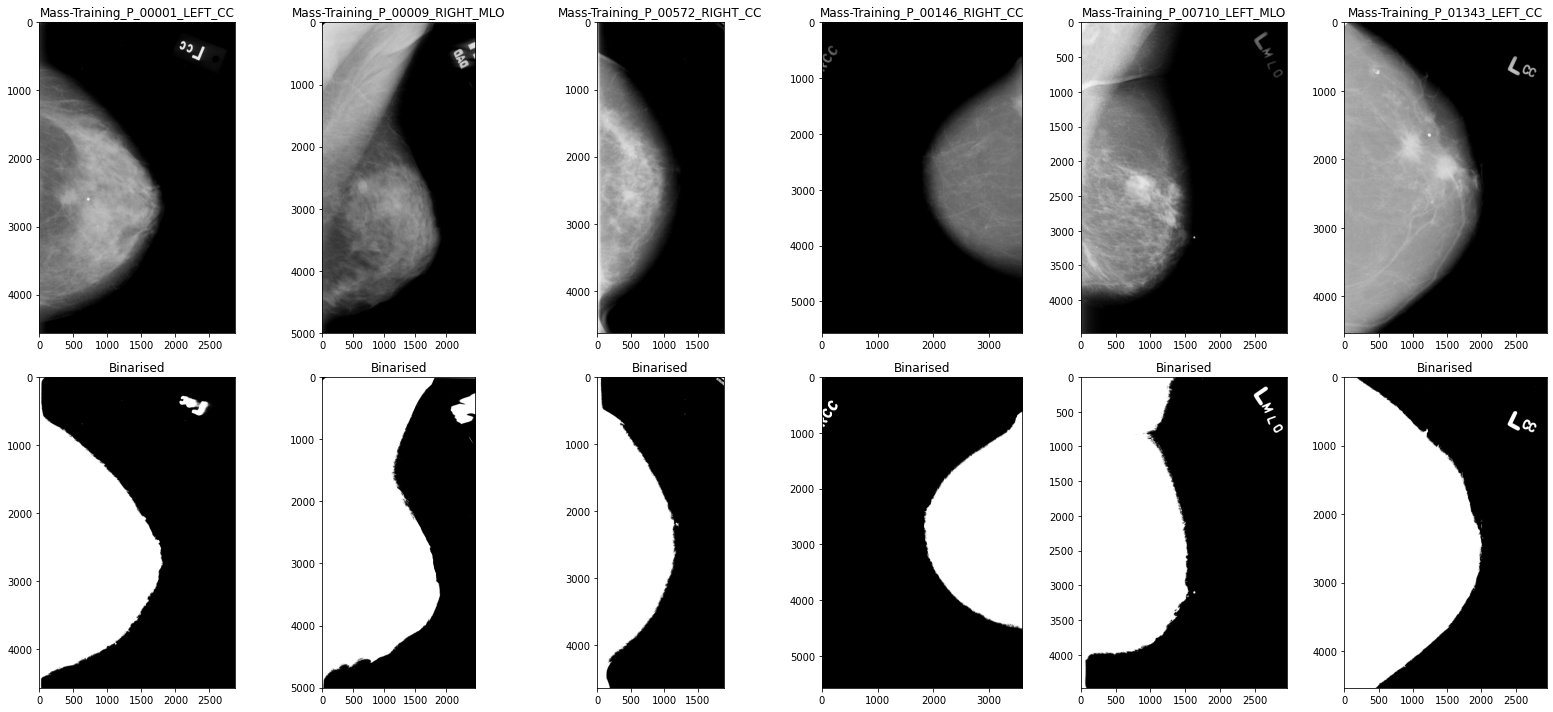

In [46]:
own_binarised_img_list = []

# Plot binarised images
fig, ax = plt.subplots(nrows=2, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
    # Plot own binarised image.
    binarised_img = OwnGlobalBinarise(img=cropped_img_list[i], thresh=0.1, maxval=1.0)
    own_binarised_img_list.append(binarised_img)
    ax[1][i].imshow(binarised_img, cmap="gray")
    ax[1][i].set_title("Binarised")
    
plt.tight_layout()
plt.savefig(fname="../data/raw_data/visualisations_for_slides/2_binarised/binarised.png", dpi=300)

In [47]:
# Plot individually
for i in range(len(own_binarised_img_list)):
    save_path = os.path.join("../data/raw_data/visualisations_for_slides/2_binarised", f"{ds[i].PatientID}_binarised.png")
    cv2.imwrite(filename=save_path, img=own_binarised_img_list[i]*255)


#### Step 1.2 - Removing noise from mask

- **References:**
    - [Explanation of what is closing and opening of mask](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)
    - [Types of morphological operations](http://homepages.inf.ed.ac.uk/rbf/HIPR2/morops.htm)
    - [Morph types documentation](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga7be549266bad7b2e6a04db49827f9f32)
    - [`getStructuringElement()` documentation](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gac342a1bb6eabf6f55c803b09268e36dc)

In [48]:
def OpenMask(mask, ksize=(23, 23), operation="open"):

    '''
    This function edits a given mask (binary image) by performing
    closing then opening morphological operations.
    
    Parameters
    ----------
    mask : {numpy.ndarray}
        The mask to edit.
        
    Returns
    -------
    edited_mask : {numpy.ndarray}
        The mask after performing close and open morphological
        operations.
    '''
        
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)
    
    if operation == "open":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    elif operation == "close":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Then dilate
    edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)
    
    return edited_mask

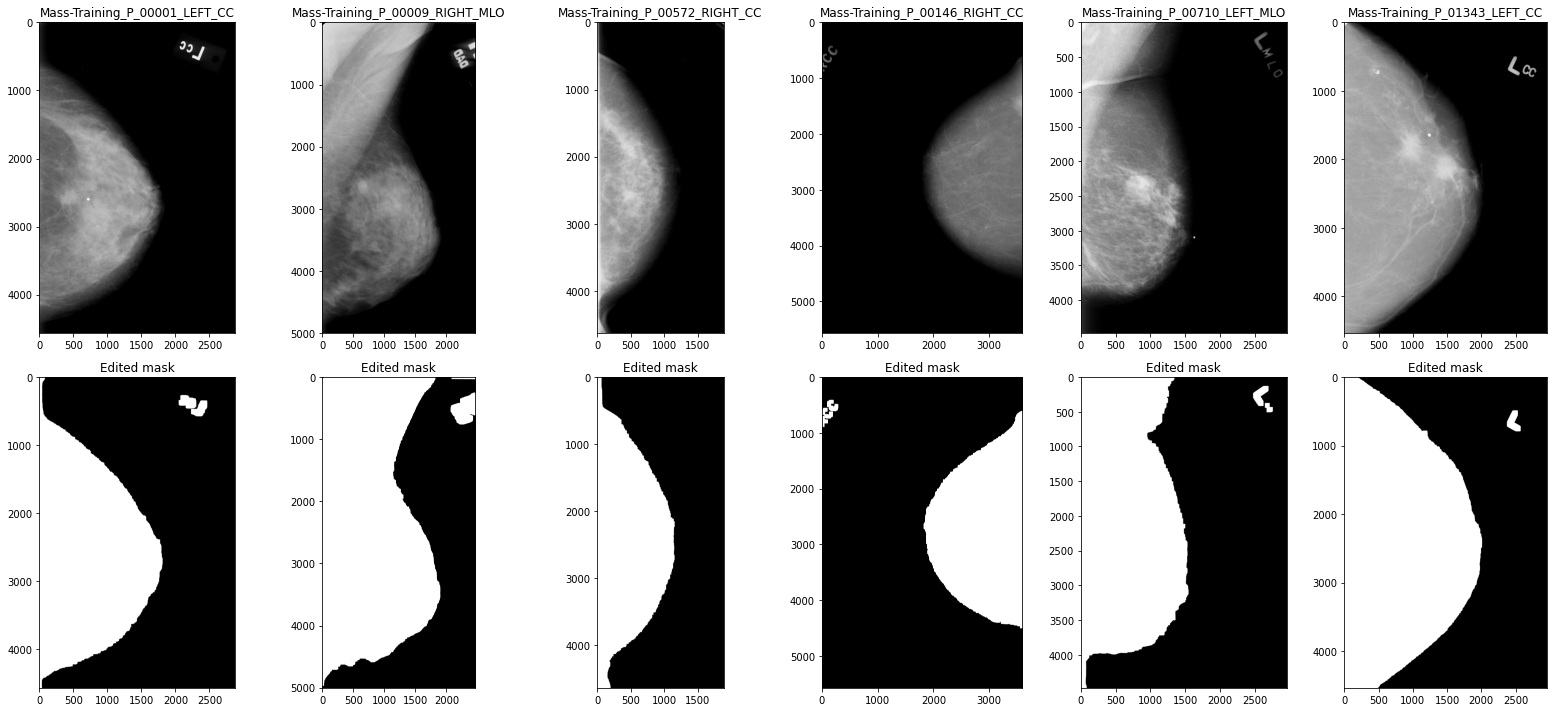

In [50]:
edited_mask_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
#     # Plot original mask.
#     ax[1][i].imshow(own_binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
    # Plot edited mask.
    edited_mask = OpenMask(mask=own_binarised_img_list[i], ksize=(33, 33), operation="open")
    edited_mask_list.append(edited_mask)
    ax[1][i].imshow(edited_mask, cmap="gray")
    ax[1][i].set_title("Edited mask")
    
plt.tight_layout()
plt.savefig(fname="../data/raw_data/visualisations_for_slides/3_remove_noise/remove_noise.png", dpi=300)

In [51]:
# Plot individually
for i in range(len(edited_mask_list)):
    save_path = os.path.join("../data/raw_data/visualisations_for_slides/3_remove_noise", f"{ds[i].PatientID}_remove_noise.png")
    cv2.imwrite(filename=save_path, img=edited_mask_list[i]*255)

#### Step 1.3 - Remove the breast region from the mask

- **References:**
    - https://stackoverflow.com/questions/49805514/extract-biggest-blob-with-opencv
    - [Contours tutorial](https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html)
    - [`cv2.findContours` documentation](https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0)
    - [`cv2.drawContours` documentation](https://docs.opencv.org/master/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc)
    - [`boundingRect` documentation](https://docs.opencv.org/3.1.0/d3/dc0/group__imgproc__shape.html#gacb413ddce8e48ff3ca61ed7cf626a366)
    - [`boundingRect` explanation with example](https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html)
    - [`contourArea` documentation](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1)
    - [Get top largest contours tutorial](https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/)
    - [`putText()` documentation](https://docs.opencv.org/master/d6/d6e/group__imgproc__draw.html#ga5126f47f883d730f633d74f07456c576)

In [52]:
def SortContoursByArea(contours, reverse=True):
    
    '''
    This function takes in list of contours, sorts them based
    on contour area, computes the bounding rectangle for each
    contour, and outputs the sorted contours and their
    corresponding bounding rectangles.
    
    Parameters
    ----------
    contours : {list}
        The list of contours to sort.
        
    Returns
    -------
    sorted_contours : {list}
        The list of contours sorted by contour area in descending
        order.
    bounding_boxes : {list}
        The list of bounding boxes ordered corresponding to the
        contours in `sorted_contours`.
    '''
    
    # Sort contours based on contour area.
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Construct the list of corresponding bounding boxes.
    bounding_boxes = [cv2.boundingRect(c) for c in sorted_contours]
    
    return sorted_contours, bounding_boxes

In [53]:
def DrawContourID(img, bounding_box, contour_id):
    
    '''
    This function draws the given contour and its ID on the given
    image. The image with the drawn contour is returned.
    
    Parameters
    ----------
    img: {numpy.ndarray}
        The image to draw the contour on.
    bounding_box : {tuple of int}
        The bounding_rect of the given contour.
    contour_id : {int or float}
        The corresponding ID of the given `contour`.
        
    Returns
    -------
    img : {numpy.ndarray}
        The image after the `contour` and its ID is drawn on.
    '''
    
    # Center of bounding_rect.
    x, y, w, h = bounding_box
    center = ( ((x + w) // 2), ((y + h) // 2) )
    
    # Draw the countour number on the image
    cv2.putText(img=img,
                text=f"{contour_id}",
                org=center, # Bottom-left corner of the text string in the image.
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=10, 
                color=(255, 255, 255),
                thickness=40)

    return img

In [54]:
def XLargestBlobs(mask, top_X=None):
    
    '''
    This function finds contours in the given image and
    keeps only the top X largest ones.
    
    Parameters
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to get the top X largest blobs.
    top_X : {int}
        The top X contours to keep based on contour area
        ranked in decesnding order.
        
        
    Returns
    -------
    n_contours : {int}
        The number of contours found in the given `mask`.
    X_largest_blobs : {numpy.ndarray}
        The corresponding mask of the image containing only
        the top X largest contours in white.
    '''
        
    # Find all contours from binarised image.
    # Note: parts of the image that you want to get should be white.
    contours, hierarchy = cv2.findContours(image=mask,
                                           mode=cv2.RETR_EXTERNAL,
                                           method=cv2.CHAIN_APPROX_NONE)
    
    n_contours = len(contours)
    
    # Only get largest blob if there is at least 1 contour.
    if n_contours > 0:
        
        # Make sure that the number of contours to keep is at most equal 
        # to the number of contours present in the mask.
        if n_contours < top_X or top_X == None:
            top_X = n_contours
        
        # Sort contours based on contour area.
        sorted_contours, bounding_boxes = SortContoursByArea(contours=contours,
                                                             reverse=True)
        
        # Get the top X largest contours.
        X_largest_contours = sorted_contours[0:top_X]
        
        # Create black canvas to draw contours on.
        to_draw_on = np.zeros(mask.shape, np.uint8)
        
        # Draw contours in X_largest_contours.
        X_largest_blobs = cv2.drawContours(image=to_draw_on, # Draw the contours on `to_draw_on`.
                                           contours=X_largest_contours, # List of contours to draw.
                                           contourIdx=-1, # Draw all contours in `contours`.
                                           color=1, # Draw the contours in white.
                                           thickness=-1) # Thickness of the contour lines.
        
    return n_contours, X_largest_blobs

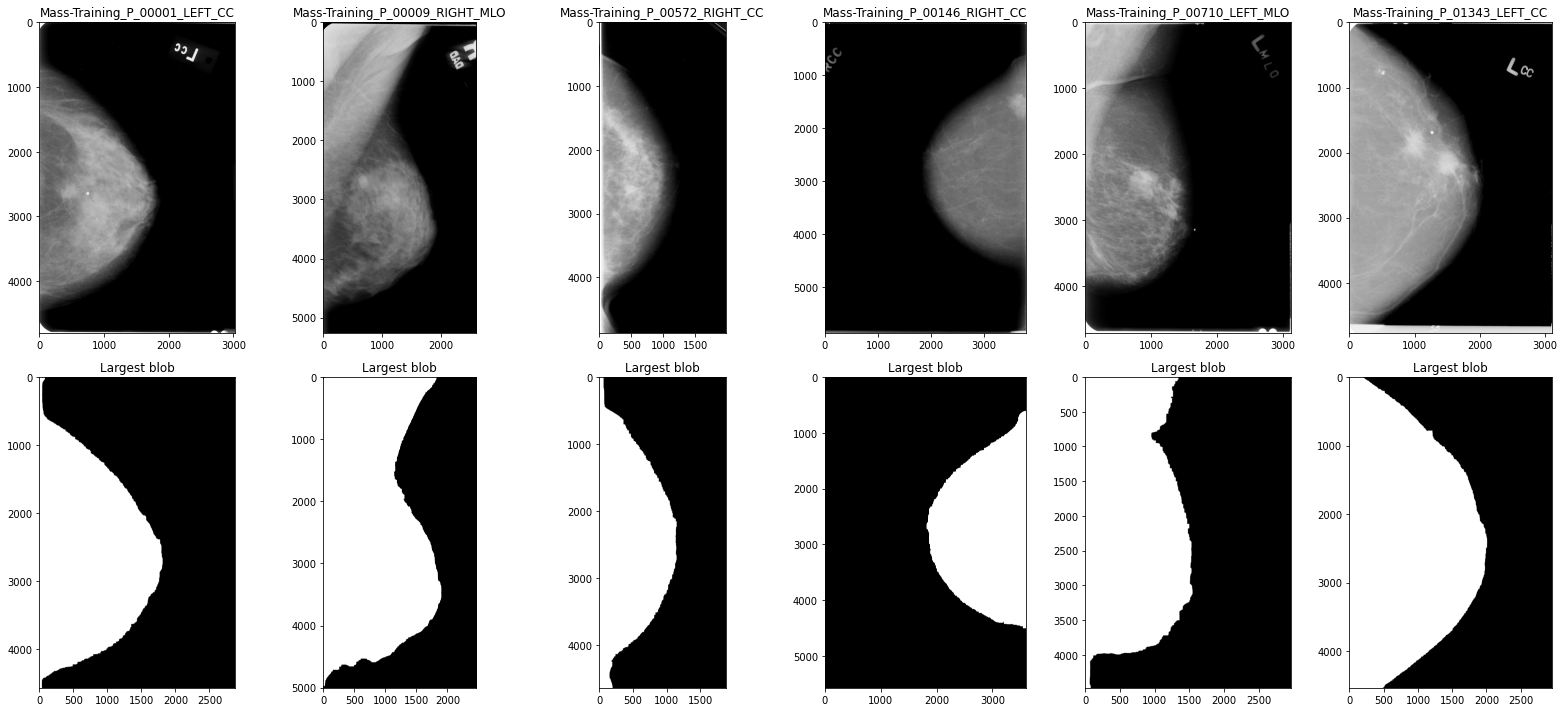

In [55]:
X_largest_blobs_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    ax[0][i].imshow(arr_norm[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
#     # Plot original mask.
#     ax[1][i].imshow(own_binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
#     # Plot edited mask.
#     ax[2][i].imshow(edited_mask_list[i], cmap="gray")
#     ax[2][i].set_title("Edited masks")
    
    # Plot largest-blob mask.
    _, X_largest_blobs = XLargestBlobs(mask=edited_mask_list[i], top_X=1)
    X_largest_blobs_list.append(X_largest_blobs)
    ax[1][i].imshow(X_largest_blobs, cmap="gray")
    ax[1][i].set_title("Largest blob")
    
plt.tight_layout()
plt.savefig(fname="../data/raw_data/visualisations_for_slides/4_largest_blob/largest_blob.png", dpi=300)

In [64]:
# Plot individually
for i in range(len(X_largest_blobs_list)):
    save_path = os.path.join("../data/raw_data/visualisations_for_slides/4_largest_blob", f"{ds[i].PatientID}_largest_blob.png")
    cv2.imwrite(filename=save_path, img=X_largest_blobs_list[i]*255)

### Step 2 - `cv2.inpaint()` with the mask

#### Step 2.1 - Invert mask

In [57]:
def InvertMask(mask):
    
    '''
    This function inverts a given mask (i.e. 0 -> 1
    and 1 -> 0).
    
    Parameters
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to invert.
        
    Returns
    -------
    inverted_mask: {numpy.ndarray}
        The inverted mask.
    '''
    
    inverted_mask = np.zeros(mask.shape, np.uint8)
    inverted_mask[mask == 0] = 1
    
    return inverted_mask

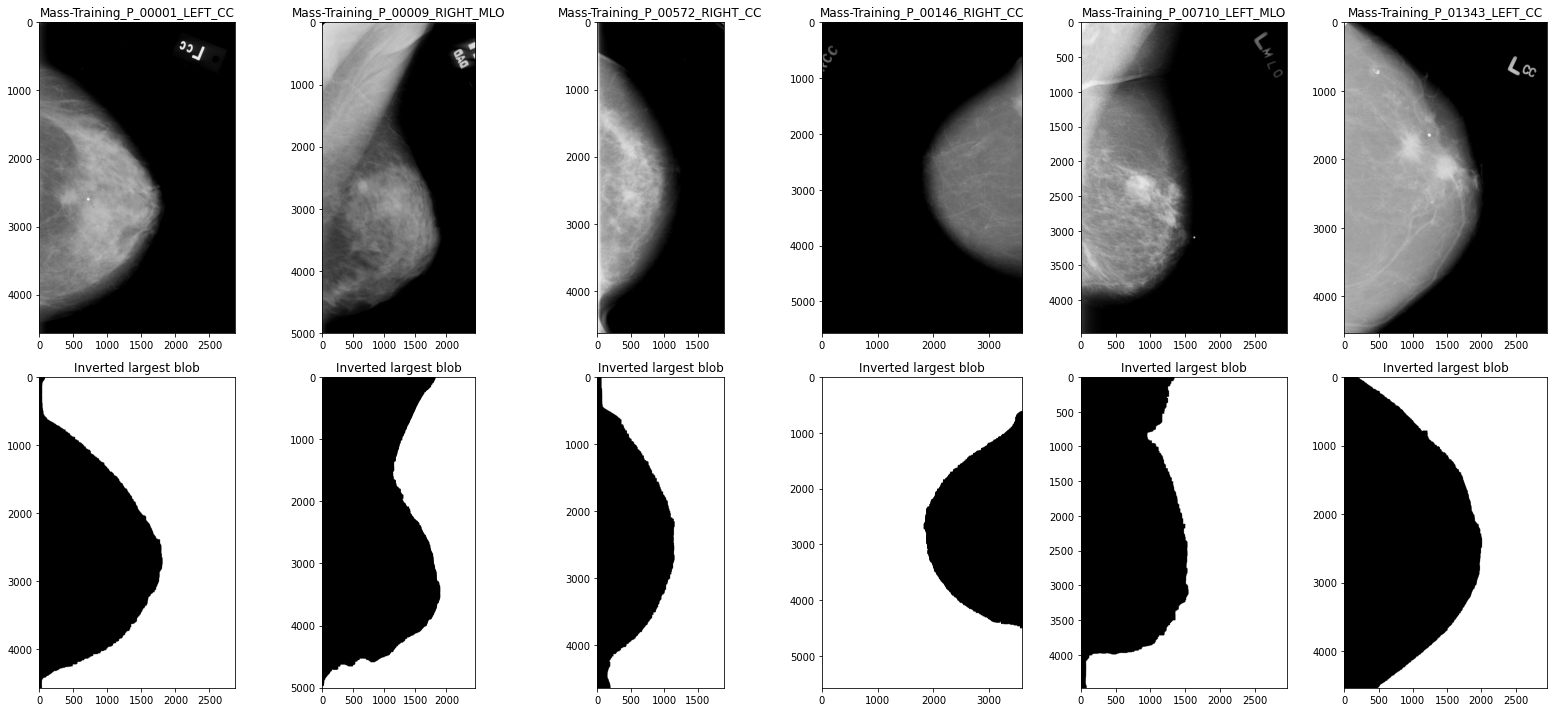

In [59]:
inverted_mask_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
#     # Plot original mask.
#     ax[1][i].imshow(binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
#     # Plot edited mask.
#     ax[2][i].imshow(edited_mask_list[i], cmap="gray")
#     ax[2][i].set_title("Edited masks")
    
#     # Plot largest-blob mask.
#     ax[3][i].imshow(X_largest_blobs_list[i], cmap="gray")
#     ax[3][i].set_title("Largest blob")
    
    # Plot inverted largest-blob mask
    inverted_mask = InvertMask(X_largest_blobs_list[i])
    inverted_mask_list.append(inverted_mask)
    ax[1][i].imshow(inverted_mask, cmap="gray")
    ax[1][i].set_title("Inverted largest blob")
    
plt.tight_layout()
plt.savefig(fname="../data/raw_data/visualisations_for_slides/5_inverted/inverted.png", dpi=300)

In [63]:
# Plot individually
for i in range(len(inverted_mask_list)):
    save_path = os.path.join("../data/raw_data/visualisations_for_slides/5_inverted", f"{ds[i].PatientID}_inverted.png")
    cv2.imwrite(filename=save_path, img=inverted_mask_list[i]*255)

#### Step 2.2 - inpaint

- **References:**
    - [Step by step explanation](https://www.pyimagesearch.com/2020/05/18/image-inpainting-with-opencv-and-python/)
    - [Image inpainting using deep learning](https://www.wandb.com/articles/introduction-to-image-inpainting-with-deep-learning)
    - [`inpaint` documentation](https://docs.opencv.org/master/d7/d8b/group__photo__inpaint.html#gaedd30dfa0214fec4c88138b51d678085)

<br>

- **Requires two images:**
    1. The original image that we wish to restore.
    2. The mask image that shows where the damage is.

In [24]:
def InPaint(img, mask, flags="telea", inpaintRadius=30):

    '''
    This function restores an input image in areas indicated
    by the given mask (elements with 1 are restored). 
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to restore.
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask that indicates where (elements == 1) in the
        `img` the damage is.
    inpaintRadius : {int}
        Radius of a circular neighborhood of each point
        inpainted that is considered by the algorithm.
        
    Returns
    -------
    inpainted_img: {numpy.ndarray}
        The restored image.
    '''
    
    # First convert to `img` from float64 to uint8.
    img = 255 * img
    img = img.astype(np.uint8)
    
    # Then inpaint based on flags.
    if flags == "telea":
        inpainted_img = cv2.inpaint(src=img,
                                    inpaintMask=mask,
                                    inpaintRadius=inpaintRadius,
                                    flags=cv2.INPAINT_TELEA)
    elif flags == "ns":
        inpainted_img = cv2.inpaint(src=img,
                                    inpaintMask=mask,
                                    inpaintRadius=inpaintRadius,
                                    flags=cv2.INPAINT_NS)
    
    return inpainted_img

In [ ]:
inpainted_img_telea_list = []

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    ax[0][i].imshow(arr_norm[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
#     # Plot original mask.
#     ax[1][i].imshow(binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
#     # Plot edited mask.
#     ax[2][i].imshow(edited_mask_list[i], cmap="gray")
#     ax[2][i].set_title("Edited masks")
    
#     # Plot largest-blob mask.
#     ax[3][i].imshow(X_largest_blobs_list[i], cmap="gray")
#     ax[3][i].set_title("Largest blob")
    
#     # Plot inverted largest-blob mask.
#     ax[4][i].imshow(inverted_mask_list[i], cmap="gray")
#     ax[4][i].set_title("Inverted largest blob")
    
    # Plot inpainted image.
    inpainted_img = InPaint(img=arr_norm[i], mask=inverted_mask_list[i], flags="telea", inpaintRadius=53)
    inpainted_img_telea_list.append(inpainted_img)
    ax[1][i].imshow(inpainted_img, cmap="gray")
    ax[1][i].set_title("Inpainted image (telea)")

# plt.tight_layout()
# plt.savefig(fname="../outputs/image-preprocessing/inpainted_telea_53.png", dpi=300)

In [ ]:
inpainted_img_ns_list = []

fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(22, 30))

for i in range(len(binarised_img_list)):
    
    # Plot original image.
    ax[0][i].imshow(arr_norm[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
    # Plot original mask.
    ax[1][i].imshow(binarised_img_list[i], cmap="gray")
    ax[1][i].set_title("Binarised")
    
    # Plot edited mask.
    ax[2][i].imshow(edited_mask_list[i], cmap="gray")
    ax[2][i].set_title("Edited masks")
    
    # Plot largest-blob mask.
    ax[3][i].imshow(X_largest_blobs_list[i], cmap="gray")
    ax[3][i].set_title("Largest blob")
    
    # Plot inverted largest-blob mask.
    ax[4][i].imshow(inverted_mask_list[i], cmap="gray")
    ax[4][i].set_title("Inverted largest blob")
    
    # Plot inpainted image.
    inpainted_img = InPaint(img=arr_norm[i], mask=inverted_mask_list[i], flags="ns", inpaintRadius=30)
    inpainted_img_ns_list.append(inpainted_img)
    ax[5][i].imshow(inpainted_img, cmap="gray")
    ax[5][i].set_title("Inpainted image (ns)")


### Step 2 EXPERIMENT - Use `X_largest_blob` as mask

In [61]:
def ApplyMask(img, mask):
    
    '''
    This function applies a mask to a given image. White
    areas of the mask are kept, while black areas are
    removed.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to mask.
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to apply.
        
    Returns
    -------
    masked_img: {numpy.ndarray}
        The masked image.
    '''
    
    masked_img = img.copy()
    masked_img[mask == 0] = 0
    
    return masked_img

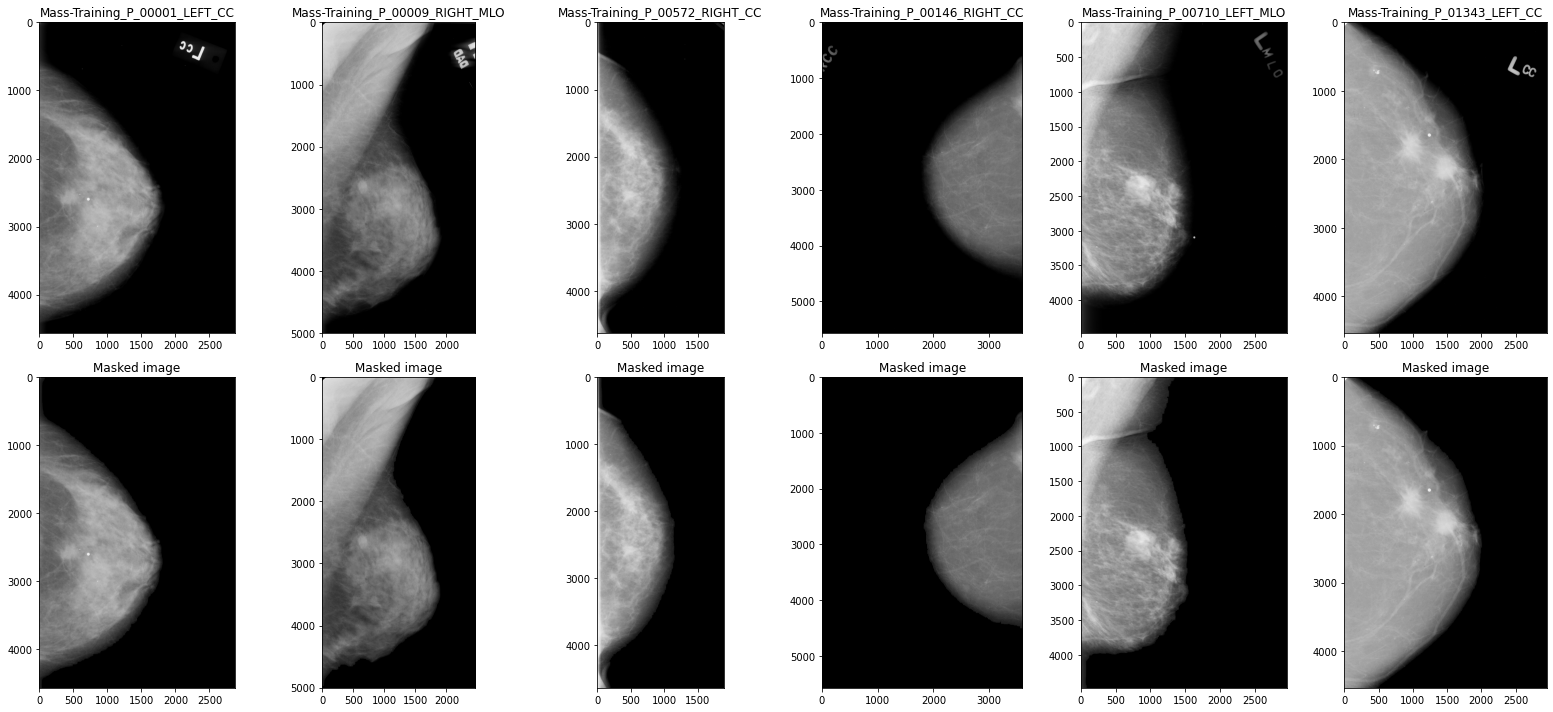

In [67]:
own_masked_img_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
#     # Plot original mask.
#     ax[1][i].imshow(binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
#     # Plot edited mask.
#     ax[2][i].imshow(edited_mask_list[i], cmap="gray")
#     ax[2][i].set_title("Edited masks")
    
#     # Plot largest-blob mask.
#     ax[3][i].imshow(X_largest_blobs_list[i], cmap="gray")
#     ax[3][i].set_title("Largest blob")
    
    # Plot applying largest-blob mask
    masked_img = ApplyMask(img=cropped_img_list[i], mask=X_largest_blobs_list[i])
    own_masked_img_list.append(masked_img)
    ax[1][i].imshow(masked_img, cmap="gray")
    ax[1][i].set_title("Masked image")

    
plt.tight_layout()
plt.savefig(fname="../data/raw_data/visualisations_for_slides/6_apply_mask/apply_mask.png", dpi=300)

In [68]:
# Plot individually
for i in range(len(own_masked_img_list)):
    save_path = os.path.join("../data/raw_data/visualisations_for_slides/6_apply_mask", f"{ds[i].PatientID}_apply_mask.png")
    cv2.imwrite(filename=save_path, img=own_masked_img_list[i]*255)

---

## Orientating the mammograms - Horizontal flip first AFTER removing pectoral muscle


### Horizontal flip

- **Why horizontal flip before removing pecs:**
    - We need all the pectoral muscles to be located in the top left corner of the frame. This is because the seed for region growing will be the top-left most pixel.

- **Observations:**
    - Reason why the function `HorizontalFlip()` returns a boolean instead of doing the actual flip is because this boolean is intended to be used in the image preprocessing pipeline to flip (or not) the corresponding mask in the dataset. 

In [69]:
def HorizontalFlip(mask):
    
    '''
    This function figures out how to flip (also entails whether
    or not to flip) a given mammogram and its mask. The correct
    orientation is the breast being on the left (i.e. facing
    right) and it being the right side up. i.e. When the
    mammogram is oriented correctly, the breast is expected to
    be found in the bottom left quadrant of the frame.
    
    Parameters
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The corresponding mask of the CC image to flip.

    Returns
    -------
    horizontal_flip : {boolean}
        True means need to flip horizontally,
        False means otherwise.
    '''
    
    # Get number of rows and columns in the image.
    nrows, ncols = mask.shape
    x_center = ncols // 2
    y_center = nrows // 2
    
    # Sum down each column.
    col_sum = mask.sum(axis=0)
    # Sum across each row.
    row_sum = mask.sum(axis=1)
    
    left_sum = sum(col_sum[0:x_center])
    right_sum = sum(col_sum[x_center:-1])
    top_sum = sum(row_sum[0:y_center])
    bottom_sum = sum(row_sum[y_center:-1])
    
    if left_sum < right_sum:
        horizontal_flip = True
    else:
        horizontal_flip = False
        
    return horizontal_flip

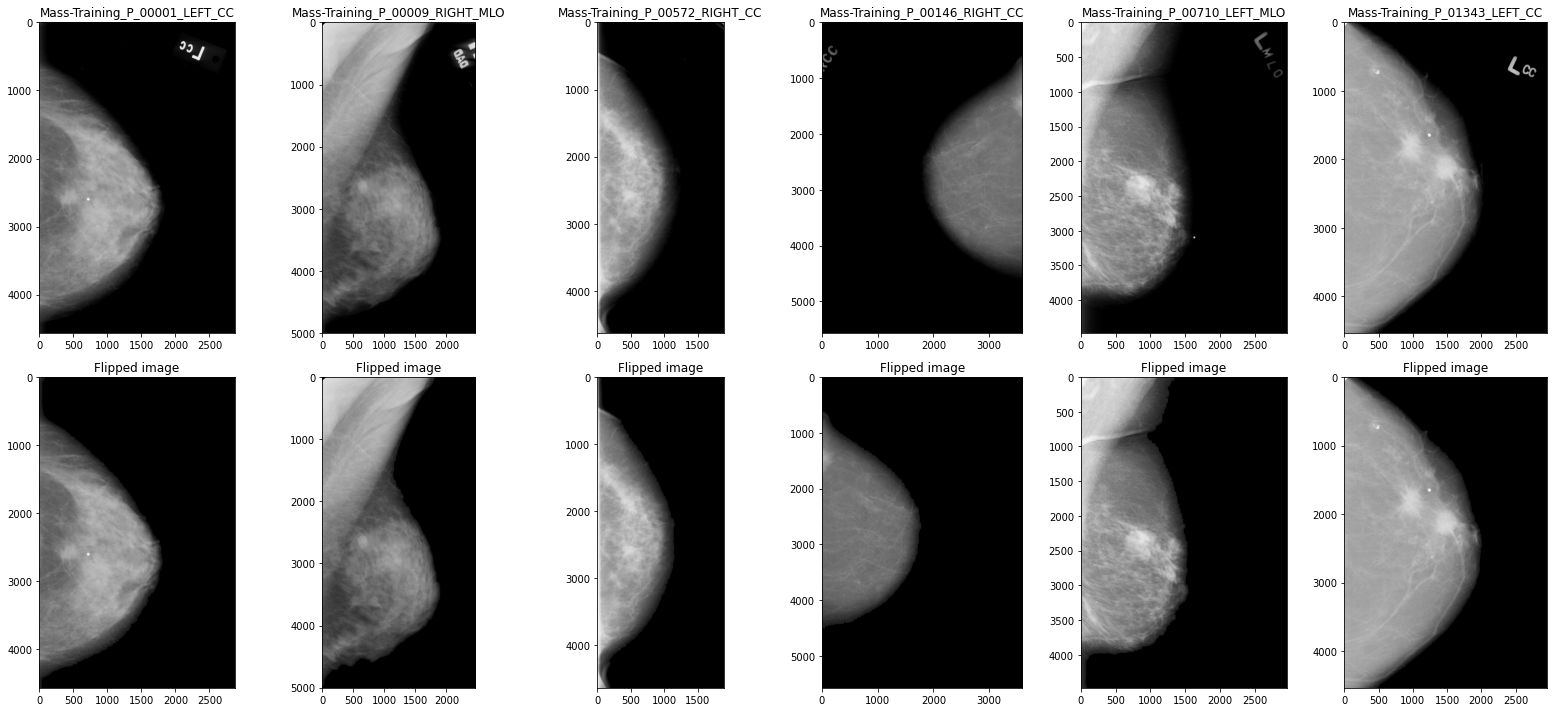

In [70]:
flipped_img_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
#     # Plot largest-blob mask.
#     ax[1][i].imshow(X_largest_blobs_list[i], cmap="gray")
#     ax[1][i].set_title("Largest blob")
    
#     # Plot final image.
#     ax[2][i].imshow(final_result_1_list[i], cmap="gray")
#     ax[2][i].set_title("FINAL RESULT")
    
    # Plot flipped image.
    horizontal_flip = HorizontalFlip(mask=X_largest_blobs_list[i])
    if horizontal_flip:
        flipped_img = np.fliplr(own_masked_img_list[i])
        flipped_img_list.append(flipped_img)
    else:
        flipped_img_list.append(own_masked_img_list[i])
    
    ax[1][i].imshow(flipped_img_list[i], cmap="gray")
    ax[1][i].set_title("Flipped image")

plt.tight_layout()
plt.savefig(fname="../data/raw_data/visualisations_for_slides/7_flipped/flipped.png", dpi=300)

In [71]:
# Plot individually
for i in range(len(flipped_img_list)):
    save_path = os.path.join("../data/raw_data/visualisations_for_slides/7_flipped", f"{ds[i].PatientID}_flipped.png")
    cv2.imwrite(filename=save_path, img=flipped_img_list[i]*255)

---

## Contrast-Limited Adaptive Histogram Equalisation (CLAHE) 

In [72]:
def clahe(img, clip=2.0, tile=(8, 8)):
    
    '''
    This function applies the Contrast-Limited Adaptive
    Histogram Equalisation filter to a given image.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to edit.
    clip : {int or floa}
        Threshold for contrast limiting.
    tile : {tuple (int, int)}
        Size of grid for histogram equalization. Input
        image will be divided into equally sized
        rectangular tiles. `tile` defines the number of
        tiles in row and column.
    
    Returns
    -------
    clahe_img : {numpy.ndarray}
        The edited image.
    '''
    
    # Convert to uint8.
    # img = skimage.img_as_ubyte(img)
    img = cv2.normalize(
        img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )
    img_uint8 = img.astype("uint8")

    clahe_create = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    clahe_img = clahe_create.apply(img_uint8)

    return clahe_img

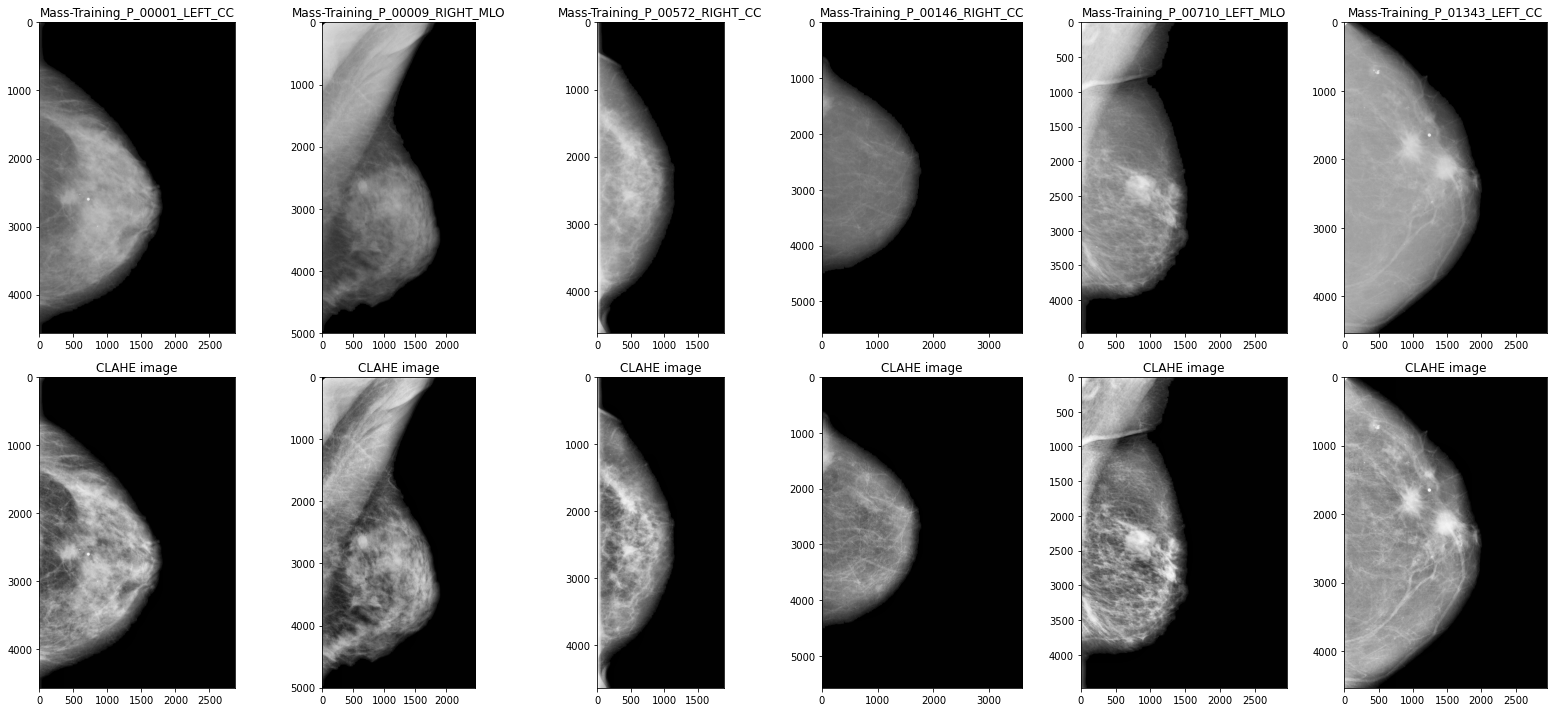

In [74]:
clahe_img_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    ax[0][i].imshow(flipped_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
#     # Plot largest-blob mask.
#     ax[1][i].imshow(X_largest_blobs_list[i], cmap="gray")
#     ax[1][i].set_title("Largest blob")
    
#     # Plot final image.
#     ax[2][i].imshow(final_result_1_list[i], cmap="gray")
#     ax[2][i].set_title("FINAL RESULT")
    
    # CLAHE enhancement.
    clahe_img = clahe(img=flipped_img_list[i])
    clahe_img_list.append(clahe_img)
    
    ax[1][i].imshow(clahe_img_list[i], cmap="gray")
    ax[1][i].set_title("CLAHE image")

plt.tight_layout()
plt.savefig(fname="../data/raw_data/visualisations_for_slides/8_clahe/clahe.png", dpi=300)

In [76]:
# Plot individually
for i in range(len(clahe_img_list)):
    save_path = os.path.join("../data/raw_data/visualisations_for_slides/8_clahe", f"{ds[i].PatientID}_clahe.png")
    cv2.imwrite(filename=save_path, img=clahe_img_list[i])

---

## Removal of pectoral muscle

Refer to `removePectoral.ipynb`.

---

## Orientating the mammograms - Vertical flip first AFTER removing pectoral muscle


### Vertical Flip

# !!! KIV !!!

- **Why:**
    - To determine whether or not to flip vertically, it depends on the angle of the scan (CC or MLO).
    - Because the breast is intended to be in the lower left quadrant of the frame, a comparison of the sum of the pixels in the top half and the bottom half of the picture is used to determine whether or not an image should be flipped vertically.
    - For CC:
        - This is straight forward. If `top_sum > bottom_sum`, then we need to flip vertically.
        - **`VerticalFlipCC(mask)`**
    - For MLO:
        - Not as straight forward due to the presence of pectoral muscle. We should determine the orientation of the image based on the location of the pectoral muscle.
        - If the pectoral muscle is located in the **top left OR right** corners, the image is the right side up.
        - If the pectoral muscle is located in the **bottom left OR right** corners, then the image needs to be flipped vertically.
        - **`VerticalFlipMLO(pec_mask)`**

---

## Padding

- **Proposed method:**
    - Step 1: Pad into a square
    - Step 2: Resize (downsample)

### Step 1 - Pad into a square

In [77]:
def Pad(img):
    
    '''
    This function pads a given image with black pixels,
    along its shorter side, into a square and returns
    the square image.
    
    If the image is portrait, black pixels will be
    padded on the right to form a square.
    
    If the image is landscape, black pixels will be
    padded on the bottom to form a square.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to pad.

    Returns
    -------
    padded_img : {numpy.ndarray}
        The padded square image, if padding was required
        and done.
    img : {numpy.ndarray}
        The original image, if no padding was required.
    '''
    
    nrows, ncols = img.shape
    
    # If padding is required...
    if nrows != ncols:
        
        # Take the longer side as the target shape.    
        if ncols < nrows:
            target_shape = (nrows, nrows)
        elif nrows < ncols:
            target_shape = (ncols, ncols)
        
        # Pad.
        padded_img = np.zeros(shape=target_shape)
        padded_img[ :nrows, :ncols ] = img
        
        return padded_img
    
    # If padding is not required, return original image.
    elif nrows == ncols:
        
        return img

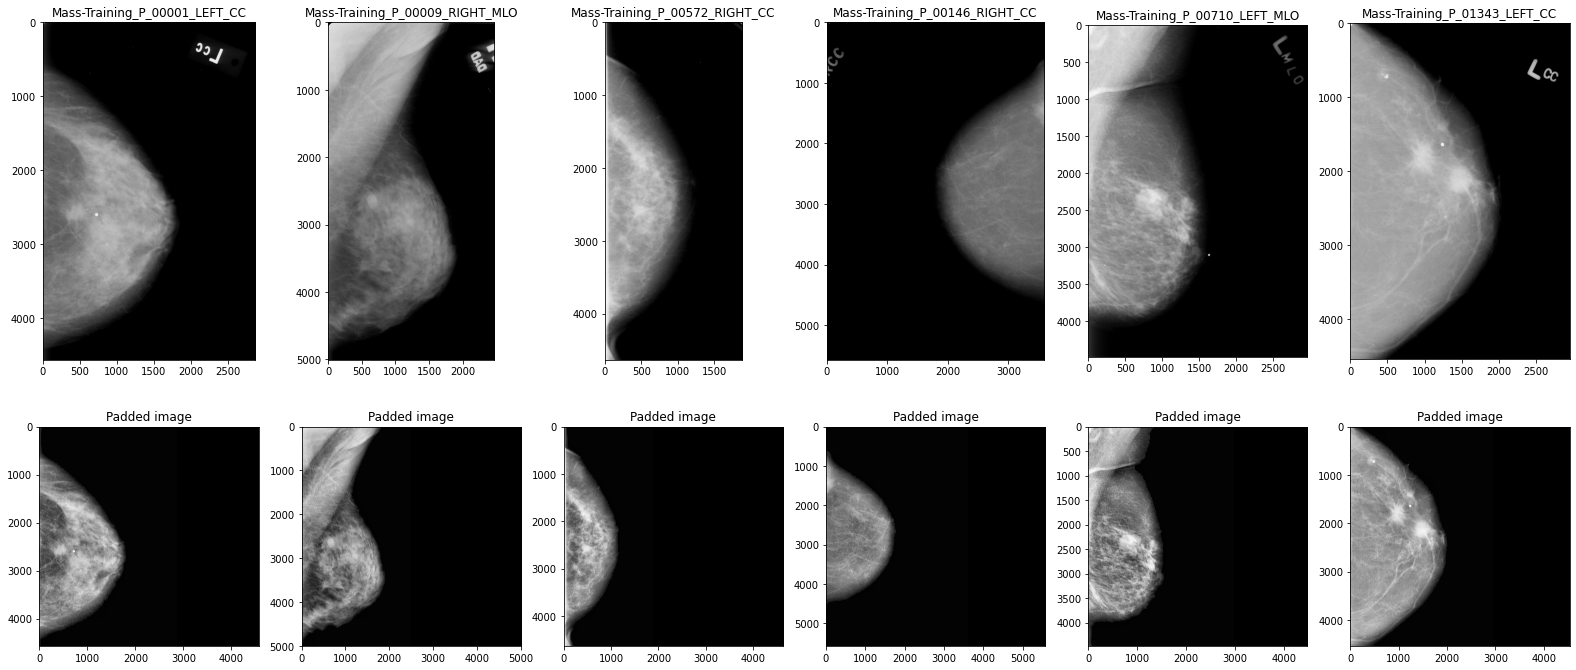

In [78]:
padded_img_list = []

fig, ax = plt.subplots(nrows=2, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    ax[0][i].set_title(f"{ds[i].PatientID}")
    
#     # Plot flipped image.
#     ax[1][i].imshow(flipped_img_list[i], cmap="gray")
#     ax[1][i].set_title("Flipped image")
    
    # Plot padded image.
    padded_img = Pad(img=clahe_img_list[i])
    padded_img_list.append(padded_img)
    ax[1][i].imshow(padded_img, cmap="gray")
    ax[1][i].set_title("Padded image")

plt.tight_layout()
plt.savefig(fname="../data/raw_data/visualisations_for_slides/9_pad/pad.png", dpi=300)

In [79]:
# Plot individually
for i in range(len(padded_img_list)):
    save_path = os.path.join("../data/raw_data/visualisations_for_slides/9_pad", f"{ds[i].PatientID}_pad.png")
    cv2.imwrite(filename=save_path, img=padded_img_list[i])

### Step 2 - Downsample